In [1]:
import warnings

import os.path as op
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from ordering_methods import create_order_3_channels, create_order_single_channel

In [2]:
# prefix = "/work/scratch/malinoro/histogram_transfer/data"
prefix = "/Users/roman/Code/Histogram_transfer/data/"

# Reading or creating images

In [3]:
img1 = cv.cvtColor(cv.imread(op.join(prefix, "MiddleBury", "cones.ppm")), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread(op.join(prefix, "MiddleBury", "teddy.ppm")), cv.COLOR_BGR2RGB)
img1 = cv.resize(img1, dsize=(360, 300))
img2 = cv.resize(img2, dsize=(360, 300))

## Fake image
X, Y = np.meshgrid(np.linspace(0, 255, img1.shape[1]), np.linspace(0, 255, img1.shape[0]))
R, G, B = np.sqrt((X**2+Y**2)/2), np.sqrt(((255-X)**2+Y**2)/2), np.sqrt(((255-X)**2+(255-Y)**2)/2)
warnings.warn("Using numpy.astype method which always work but can be dependent of OS and other obscure stuff.\nBe sure to check that it casts correctly on your computer")
R, G, B = R.astype(dtype=np.uint8), G.astype(dtype=np.uint8), B.astype(dtype=np.uint8)
img0 = cv.merge([R, G, B])

/var/folders/kn/x94nsr4955n7vthghm5m3mfw0000gn/T/ipykernel_21208/3615047429.py:9: UserWarning: Using numpy.astype method which always work but can be dependent of OS and other obscure stuff.
Be sure to check that it casts correctly on your computer
  warnings.warn("Using numpy.astype method which always work but can be dependent of OS and other obscure stuff.\nBe sure to check that it casts correctly on your computer")


# Choosing and image, smoothing it, HSV, and separating channels

In [4]:
img = img1
img_ref = img2

# HSV
hsv_img = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv_ref = cv.cvtColor(img_ref, cv.COLOR_RGB2HSV)

# Smooth image
img_smooth = cv.GaussianBlur(img, (5, 5), 0)
hsv_smooth = cv.GaussianBlur(hsv_img, (5, 5), 0)

# Separating channels
rgb_planes = cv.split(img)
rgb_ref_planes = cv.split(img_ref)
rgb_smooth_planes = cv.split(img_smooth)

hsv_planes = cv.split(hsv_img)
hsv_ref_planes = cv.split(hsv_ref)
hsv_smooth_planes = cv.split(hsv_smooth)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axes[0,0].imshow(img)
axes[0,1].imshow(img_smooth)

n_bins = 80
for k, c in zip(range(3), ["r", "g", "b"]):
    counts, bins = np.histogram(rgb_planes[k], bins=n_bins, density=True)
    axes[1,0].stairs(counts, bins, color=c)
    axes[1,1].stairs(np.cumsum(counts), bins, baseline=None, color=c)
    
plt.show()


In [ ]:
cumulated_hist = True

bins_3d = (20, 20, 20)
X, Y, Z = np.meshgrid(*[np.linspace(0, 255, b) for b in bins_3d])

# This compute the histogram in N dimensions
if cumulated_hist:
    counts, _ = np.histogramdd(np.array(img).reshape(-1, 3), bins=bins_3d)
    counts = counts.cumsum(axis=0).cumsum(axis=1).cumsum(axis=2) / np.sum(counts)
    iso_min, iso_max = 0, 1
else:
    counts, _ = np.histogramdd(np.array(img).reshape(-1, 3), bins=bins_3d, density=True)
    iso_min, iso_max = np.quantile(counts, 0.5), counts.max()

    
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    isomin=iso_min,
    isomax=iso_max,
    value=counts.flatten(),
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))

fig.update_layout(autosize=False, width=500, height=500, scene=dict(xaxis_title='Red', yaxis_title='Green', zaxis_title='Blue'))
fig.show()

### Verifying that the histogram is correctly computed

## Sorting the image for RGB

In [6]:
order_ref = create_order_3_channels(img_ref)
order = create_order_3_channels(img, img_smooth)

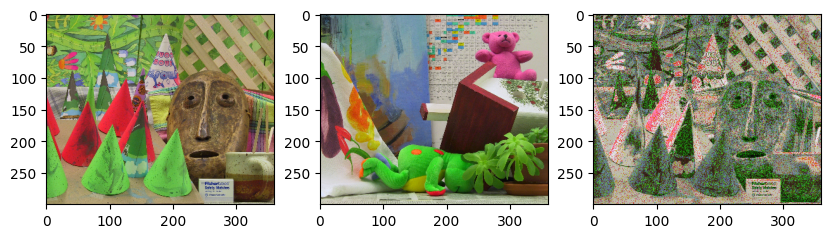

In [7]:
img_transfered = img.copy()
img_transfered[order] = img_ref[order_ref]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(img_transfered)

## Sorting the image for RGB taken separetly

In [8]:
r_order_ref = create_order_single_channel(rgb_ref_planes[0])
r_order = create_order_single_channel(rgb_planes[0], rgb_smooth_planes[0])
r_transfered = rgb_planes[0].copy()
r_transfered[r_order] = rgb_ref_planes[0][r_order_ref]

g_order_ref = create_order_single_channel(rgb_ref_planes[1])
g_order = create_order_single_channel(rgb_planes[1], rgb_smooth_planes[1])
g_transfered = rgb_planes[1].copy()
g_transfered[g_order] = rgb_ref_planes[1][g_order_ref]

b_order_ref = create_order_single_channel(rgb_ref_planes[2])
b_order = create_order_single_channel(rgb_planes[2], rgb_smooth_planes[2])
b_transfered = rgb_planes[2].copy()
b_transfered[b_order] = rgb_ref_planes[2][b_order_ref]

img_channels_transfered = cv.merge([r_transfered, g_transfered, b_transfered])

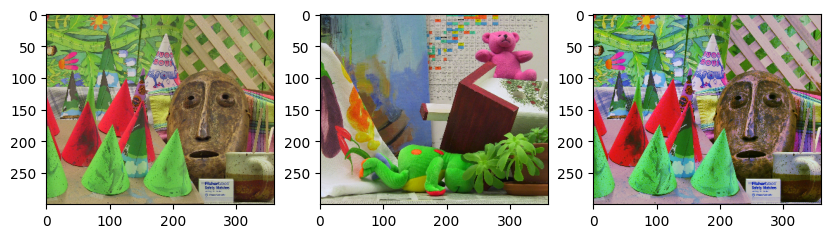

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(img_channels_transfered)

plt.show()

## Sorting the image for HSV

In [10]:
order_ref = create_order_3_channels(hsv_ref)
order = create_order_3_channels(hsv_img, hsv_smooth)

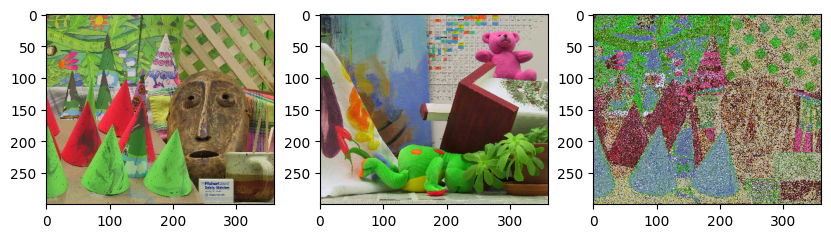

In [11]:
hsv_transfered = hsv_img.copy()
hsv_transfered[order] = hsv_ref[order_ref]
hsv_transfered = cv.cvtColor(hsv_transfered, cv.COLOR_HSV2RGB)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(hsv_transfered)

## Sorting the image for HSV taken separetly

In [12]:
h_order_ref = create_order_single_channel(hsv_ref_planes[0])
h_order = create_order_single_channel(hsv_planes[0], hsv_smooth_planes[0])
h_transfered = hsv_planes[0].copy()
h_transfered[h_order] = hsv_ref_planes[0][h_order_ref]

s_order_ref = create_order_single_channel(hsv_ref_planes[1])
s_order = create_order_single_channel(hsv_planes[1], hsv_smooth_planes[1])
s_transfered = hsv_planes[1].copy()
s_transfered[s_order] = hsv_ref_planes[1][s_order_ref]

v_order_ref = create_order_single_channel(hsv_ref_planes[2])
v_order = create_order_single_channel(hsv_planes[2], hsv_smooth_planes[2])
v_transfered = hsv_planes[2].copy()
v_transfered[v_order] = hsv_ref_planes[2][v_order_ref]

hsv_channels_transfered = cv.cvtColor(cv.merge([h_transfered, s_transfered, v_transfered]), cv.COLOR_HSV2RGB)

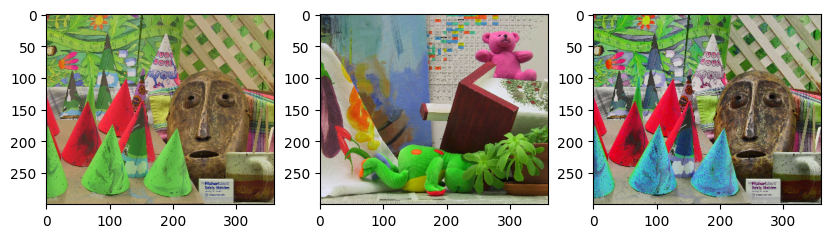

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(hsv_channels_transfered)

plt.show()

# Plotting all methods at once

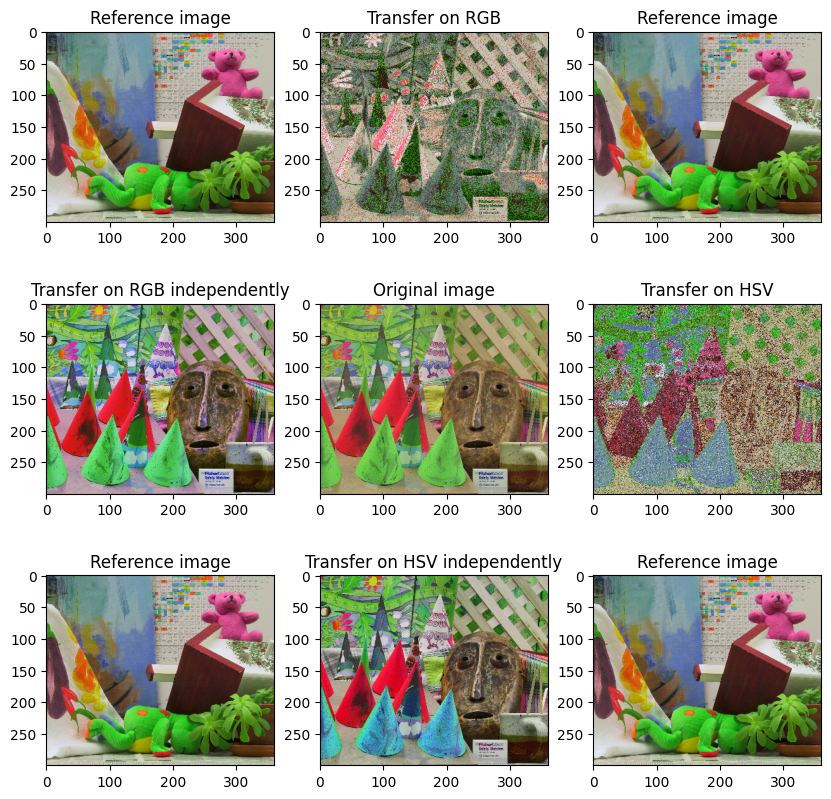

In [14]:
hsv_channels_transfered 
hsv_transfered 
img_channels_transfered
img_transfered

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes[0,1].imshow(img_transfered)
axes[1,0].imshow(img_channels_transfered)
axes[1,2].imshow(hsv_transfered)
axes[2,1].imshow(hsv_channels_transfered)

axes[0,1].set_title("Transfer on RGB")
axes[1,0].set_title("Transfer on RGB independently")
axes[1,2].set_title("Transfer on HSV")
axes[2,1].set_title("Transfer on HSV independently")


axes[0,0].imshow(img_ref)
axes[0,2].imshow(img_ref)
axes[2,0].imshow(img_ref)
axes[2,2].imshow(img_ref)
axes[1,1].imshow(img)

axes[0,0].set_title("Reference image")
axes[0,2].set_title("Reference image")
axes[2,0].set_title("Reference image")
axes[2,2].set_title("Reference image")
axes[1,1].set_title("Original image")

plt.show()